#### Importing packages

In [1]:
# Importing the scripts
from webdesign.polls.scripts import preprocess
from webdesign.polls.scripts import categorize
from webdesign.polls.scripts import analyze
from webdesign.polls.scripts import visualize
from webdesign.polls.scripts import forecast

# Importing other packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Workflow 

In [2]:
def single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size=None,custom_range=None,title=None):
    pp_ts = preprocess.fill_dates(input_ts,freq) 
    pp_ts = preprocess.fill_values(pp_ts,fill_method)
    pp_ts = preprocess.smoothing(pp_ts,smooth_window)

    if cat_method[0] == 'L':
        cat_ts, bin_bounds = categorize.level_categorize(pp_ts,cat_method,num_bins,custom_range)
    else:
        trend_ts, (cat_ts, bin_bounds) = categorize.trend_categorize(pp_ts,cat_method,win_size,num_bins,custom_range)

    if workflow_type == 'single':
        ### display plots and table only for single time series workflow
        if cat_method[0] == 'L':
            visualize.single_ts_level_plot_nosave(pp_ts,cat_ts,bin_bounds,title)
        else:
            visualize.single_ts_trend_plot_nosave(pp_ts,trend_ts,cat_ts,bin_bounds,title)
        display(analyze.single_ts_analyze(cat_ts,bin_bounds,freq))
    else:
        return cat_ts

### Single Time Series

#### Parameters

In [ ]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'T-rate'
num_bins = 8
win_size = 14
#custom_range = (0,500)

In [ ]:
workflow_type = 'single'
freq = 'D'
input_ts = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_covid_admissions.csv',parse_dates=['date'])

In [ ]:
input_ts

In [ ]:
single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)

### Multi Time series

#### Parameters

In [ ]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'L-qcut'
num_bins = 8
win_size = 14
#custom_range = (0,500)

In [ ]:
workflow_type = 'multi-signal'
freq = 'W'
input_df = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_cases_cli_viralload.csv',parse_dates=['date'],index_col=0)

In [ ]:
cat_df = pd.DataFrame()
for column in input_df.columns:
    print(input_df)
    signal_ts = input_df[[column]]
    signal_ts.columns = ['value']
    input_ts = signal_ts.reset_index()
    printmd("**"+column+"**")
    single_ts_workflow(input_ts,'single',freq,fill_method,smooth_window,cat_method,num_bins,win_size,title=column)
    cat_ts = single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)
    cat_df = pd.concat([cat_df,cat_ts],axis=1)
cat_df.columns = input_df.columns
cat_df

In [ ]:
visualize.multi_signal_plot(cat_df,cat_method)

In [ ]:
chi_df, pval_df, csq_str_df = analyze.multi_ts_analyze(cat_df)

In [ ]:
visualize.multi_cat_csq(chi_df,csq_str_df)

### Forecast

In [3]:
#qfct, cat_fct = forecast.fcast_example()
loc='US'
data_cutoff='2024-03-16'
obs_date=pd.to_datetime(data_cutoff)

fname='https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv'
df=pd.read_csv(fname,parse_dates=['date'])

input_ts=df.pivot(index='date',columns='location',values='value')[loc].reset_index()
input_ts.columns = ['date','value']

In [4]:
workflow_type = 'single'
freq = 'W'
fill_method = 'linear'
smooth_window = 1
cat_method = 'L-qcut'
num_bins = 8

In [5]:
input_ts

,date,value
0,2022-02-12,1237
1,2022-02-19,1512
2,2022-02-26,1669
3,2022-03-05,1889
4,2022-03-12,2223
...,...,...
108,2024-03-09,9117
109,2024-03-16,7272
110,2024-03-23,5904
111,2024-03-30,5430


,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(572.0, 708.0)",15,13.27%,5.0
1,Q2,"(708.0, 908.0)",14,12.39%,2.0
2,Q3,"(908.0, 1237.0)",14,12.39%,2.3
3,Q4,"(1237.0, 1889.0)",14,12.39%,2.8
4,Q5,"(1889.0, 3069.0)",14,12.39%,2.8
5,Q6,"(3069.0, 5430.0)",14,12.39%,2.8
6,Q7,"(5430.0, 11016.0)",14,12.39%,3.5
7,Q8,"(11016.0, 26602.0)",14,12.39%,7.0


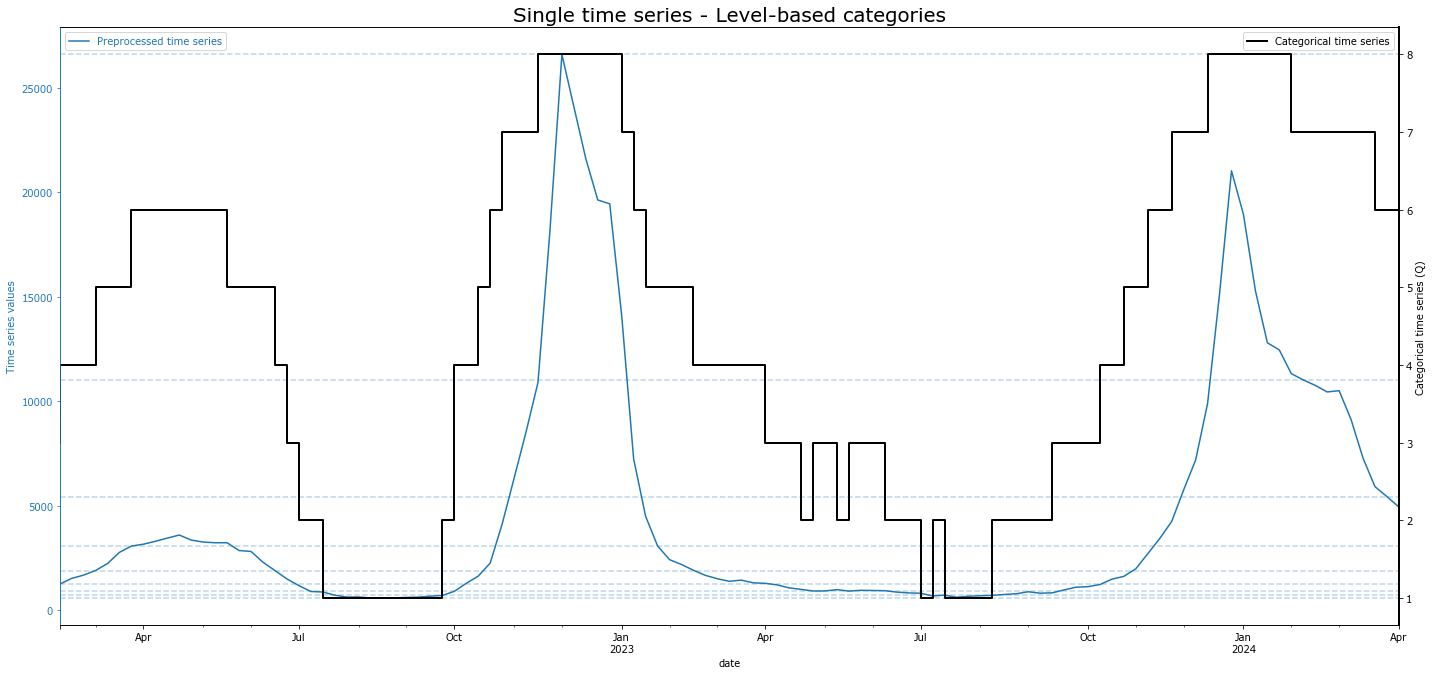

In [6]:
single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins)

In [7]:
qfct, cat_fct = forecast.ARIMA_func(input_ts,cat_method,num_bins)

'20240416203432793475.png'

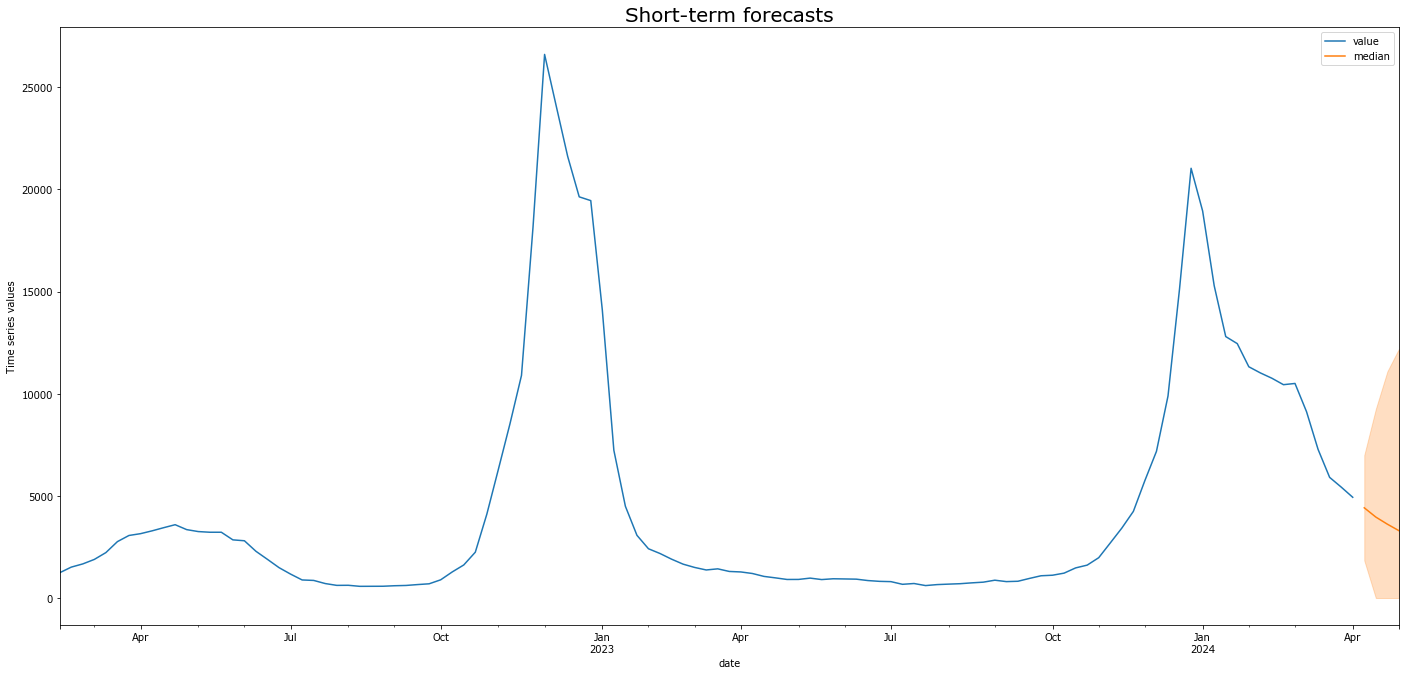

In [8]:
visualize.fcast_plot(input_ts,qfct)

'20240416203433186840.png'

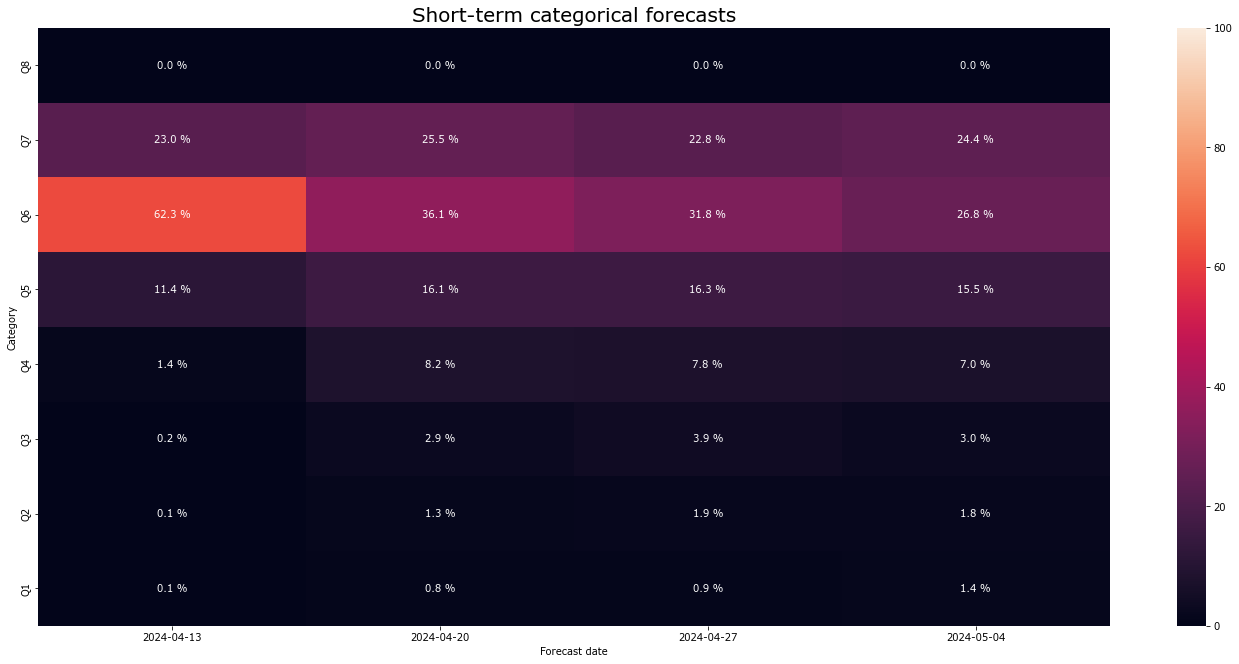

In [9]:
visualize.cat_fcast_plot(cat_fct)

In [12]:
input_ts.to_csv('/Users/vsriniv/Desktop/test_ts.csv',index=None)

In [10]:
cat_fct.groupby('target_end_date')['value'].sum()

target_end_date
2024-04-13    0.985932
2024-04-20    0.907790
2024-04-27    0.853926
2024-05-04    0.800215
Name: value, dtype: float64